In [32]:
from dask_gateway import Gateway
gateway = Gateway()
# cluster = GatewayCluster()
options = gateway.cluster_options()

options.worker_cores = 8 # 16 #16 / 4
options.worker_memory = 32 # 32 #32 / 8  

cluster = gateway.new_cluster(options)

cluster.adapt(minimum = 2, maximum = 150)

client = cluster.get_client() 
cluster

In [34]:
client.close()
cluster.close()

In [ ]:
# filter some warning messages
import warnings
warnings.filterwarnings("ignore") 

In [1]:
# get cm4 so and thetao data ('gn' without regriding)
from intake import open_catalog
url = "https://raw.githubusercontent.com/pangeo-data/pangeo-datastore/master/intake-catalogs/master.yaml"
col = open_catalog(url).climate.cmip6_gcs()

dslist = col.search(variable_id = ['so', 'thetao'], table_id = 'Omon', experiment_id = 'piControl', 
           source_id = 'GFDL-CM4', grid_label = 'gn')
ds = dslist['CMIP.NOAA-GFDL.GFDL-CM4.piControl.Omon.gn'].to_dask()
ds = ds.squeeze('member_id').reset_coords('member_id', drop = True)

In [1]:
import numpy as np
import xesmf as xe
import xarray as xr

import copy
import gsw

In [3]:
ds

<xarray.Dataset>
Dimensions:    (bnds: 2, y: 1080, x: 1440, vertex: 4, lev: 35, time: 6000)
Coordinates:
  * bnds       (bnds) float64 1.0 2.0
    lat        (y, x) float32 dask.array<chunksize=(1080, 1440), meta=np.ndarray>
    lat_bnds   (y, x, vertex) float32 dask.array<chunksize=(1080, 1440, 4), meta=np.ndarray>
  * lev        (lev) float64 2.5 10.0 20.0 32.5 ... 5e+03 5.5e+03 6e+03 6.5e+03
    lev_bnds   (lev, bnds) float64 dask.array<chunksize=(35, 2), meta=np.ndarray>
    lon        (y, x) float32 dask.array<chunksize=(1080, 1440), meta=np.ndarray>
    lon_bnds   (y, x, vertex) float32 dask.array<chunksize=(1080, 1440, 4), meta=np.ndarray>
  * time       (time) object 0151-01-16 12:00:00 ... 0650-12-16 12:00:00
    time_bnds  (time, bnds) object dask.array<chunksize=(6000, 2), meta=np.ndarray>
  * x          (x) float64 -299.7 -299.5 -299.2 -299.0 ... 59.53 59.78 60.03
  * y          (y) float64 -80.39 -80.31 -80.23 -80.15 ... 89.73 89.84 89.95
Dimensions without coordinates: vertex
Data variables:
    so         (time, lev, y, x) float32 dask.array<chunksize=(2, 35, 1080, 1440), meta=np.ndarray>
    thetao     (time, lev, y, x) float32 dask.array<chunksize=(1, 35, 1080, 1440), meta=np.ndarray>
Attributes: (12/47)
    further_info_url:        https://furtherinfo.es-doc.org/CMIP6.NOAA-GFDL.G...
    version_id:              v20180701
    variant_label:           r1i1p1f1
    realization_index:       1
    parent_source_id:        GFDL-CM4
    branch_time_in_parent:   54750.0
    ...                      ...
    table_id:                Omon
    institution:             National Oceanic and Atmospheric Administration,...
    history:                 File was processed by fremetar (GFDL analog of C...
    grid:                    ocean data on native grid tripolar - nominal 0.2...
    license:                 CMIP6 model data produced by NOAA-GFDL is licens...
    intake_esm_dataset_key:  CMIP.NOAA-GFDL.GFDL-CM4.piControl.Omon.gn

In [84]:
dz = ds.lev_bnds[:,1] - ds.lev_bnds[:,0]

In [85]:
dz.load()

<xarray.DataArray 'lev_bnds' (lev: 35)>
array([  5. ,  10. ,  10. ,  15. ,  22.5,  25. ,  25. ,  25. ,  37.5,
        50. ,  50. ,  75. , 100. , 100. , 100. , 100. , 100. , 100. ,
       100. , 100. , 100. , 100. , 100. , 175. , 250. , 375. , 500. ,
       500. , 500. , 500. , 500. , 500. , 500. , 500. , 500. ])
Coordinates:
  * lev      (lev) float64 2.5 10.0 20.0 32.5 ... 5e+03 5.5e+03 6e+03 6.5e+03

In [4]:
mldzscore = xr.open_dataset('mldzscore_cm4.nc').__xarray_dataarray_variable__

zs_weddell = mldzscore.sel(x = slice(-60, 30), y = slice(-90, -60)) 

In [5]:
ds_ws0 = ds.sel(x = slice(-60, 30), y = slice(-90, -60))

In [6]:
ds_ws = ds_ws0.where(zs_weddell>2)

In [7]:
ds_gswp = gsw.p_from_z(-ds_ws.lev, ds_ws.lat)
ds_pbnds = gsw.p_from_z(-ds_ws.lev_bnds, ds_ws.lat)
ds_sa = gsw.SA_from_SP(ds_ws.so, ds_gswp, ds_ws.lon, ds_ws.lat)
ds_ct = gsw.CT_from_t(ds_sa, ds_ws.thetao, ds_gswp)

In [8]:
ds_sigma0 = gsw.sigma0(ds_sa, ds_ct)
ds_sigma1 = gsw.sigma1(ds_sa, ds_ct)
ds_sigma2 = gsw.sigma2(ds_sa, ds_ct)

In [9]:
ds_sigma0_new = gsw.pot_rho_t_exact(ds_sa, ds_ws.thetao, ds_gswp, 0)
ds_sigma1_new = gsw.pot_rho_t_exact(ds_sa, ds_ws.thetao, ds_gswp, 1000)
ds_sigma15_new = gsw.pot_rho_t_exact(ds_sa, ds_ws.thetao, ds_gswp, 1500)
ds_sigma2_new = gsw.pot_rho_t_exact(ds_sa, ds_ws.thetao, ds_gswp, 2000)

In [14]:
ds_sigma0_avg = ds_sigma0.groupby('time.year').mean(dim='time', skipna=True).mean(dim='x', skipna=True).mean(dim='y', skipna=True)
ds_sigma1_avg = ds_sigma1.groupby('time.year').mean(dim='time', skipna=True).mean(dim='x', skipna=True).mean(dim='y', skipna=True)
ds_sigma2_avg = ds_sigma2.groupby('time.year').mean(dim='time', skipna=True).mean(dim='x', skipna=True).mean(dim='y', skipna=True)

ds_sigma0_new_avg = ds_sigma0_new.groupby('time.year').mean(dim='time', skipna=True).mean(dim='x', skipna=True).mean(dim='y', skipna=True)
ds_sigma1_new_avg = ds_sigma1_new.groupby('time.year').mean(dim='time', skipna=True).mean(dim='x', skipna=True).mean(dim='y', skipna=True)
ds_sigma15_new_avg = ds_sigma15_new.groupby('time.year').mean(dim='time', skipna=True).mean(dim='x', skipna=True).mean(dim='y', skipna=True)
ds_sigma2_new_avg = ds_sigma2_new.groupby('time.year').mean(dim='time', skipna=True).mean(dim='x', skipna=True).mean(dim='y', skipna=True)

In [15]:
ds_sigma0_avg = ds_sigma0_avg.load()

In [16]:
ds_sigma1_avg = ds_sigma1_avg.load()

In [22]:
ds_sigma2_avg = ds_sigma2_avg.load()

In [23]:
ds_sigma0_new_avg = ds_sigma0_new_avg.load()

In [53]:
ds_sigma1_new_avg = ds_sigma1_new_avg.load()

In [27]:
ds_sigma15_new_avg = ds_sigma15_new_avg.load()

In [33]:
ds_sigma2_new_avg = ds_sigma2_new_avg.load()

In [4]:
import matplotlib.pyplot as plt

import matplotlib.colors as colors
import matplotlib.cbook as cbook

In [54]:
ds_sigma1_new_avg

<xarray.DataArray 'so' (year: 500, lev: 35)>
array([[1032.24952833, 1032.26835534, 1032.30652932, ..., 1032.61547991,
                  nan,           nan],
       [1032.34537901, 1032.35592319, 1032.37646705, ..., 1032.61525523,
                  nan,           nan],
       [1032.32959932, 1032.34109921, 1032.36404001, ..., 1032.61512976,
                  nan,           nan],
       ...,
       [1032.22525401, 1032.24230124, 1032.27587722, ..., 1032.55569944,
                  nan,           nan],
       [1032.22854425, 1032.25411686, 1032.29370782, ..., 1032.55564746,
                  nan,           nan],
       [1032.26757246, 1032.27875339, 1032.30592828, ..., 1032.55557424,
                  nan,           nan]])
Coordinates:
  * lev      (lev) float64 2.5 10.0 20.0 32.5 ... 5e+03 5.5e+03 6e+03 6.5e+03
  * year     (year) int64 151 152 153 154 155 156 ... 645 646 647 648 649 650

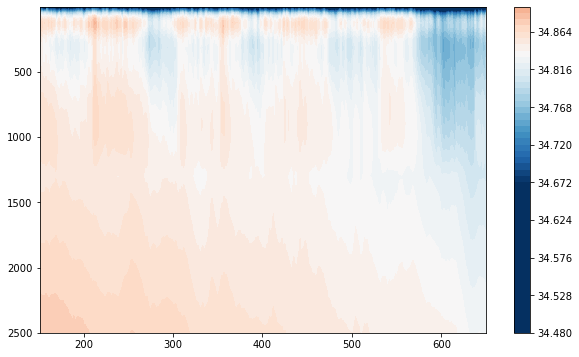

In [134]:
pltdata = ds_sigma15_new_avg - 1000
fig = plt.figure(figsize=(10,6))

levels = np.linspace(34.85, 35, 50)
pltdata = pltdata.sel(lev = slice(0, 2500))
im = plt.contourf(pltdata.year, pltdata.lev, pltdata.transpose(), levels = 50, vmin=34.67, vmax=35, cmap=plt.cm.RdBu_r)  #, norm=divnorm, 
plt.gca().invert_yaxis()
cbar = plt.colorbar(im, extend='both')

In [8]:
coninx_ws = xr.open_dataset('temp_weddellconv_cm4.nc').thetao.sel(lev = 2000, method = 'nearest').isel(year = slice(0,450))
coninx_ws = (coninx_ws - coninx_ws.mean('year'))/coninx_ws.std('year') * (-1)

In [9]:
coninx_rs = xr.open_dataset('temp_rossconv_cm4.nc').thetao.sel(lev = 2000, method = 'nearest').isel(year = slice(0,450))
coninx_rs = (coninx_rs - coninx_rs.mean('year'))/coninx_rs.std('year') * (-1)

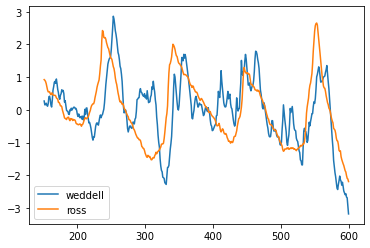

In [11]:
# fig = plt.figure(figsize=(8,6))

pltdata1 = coninx_ws
pltdata2 = coninx_rs
plt.plot(pltdata1.year, pltdata1) #, norm=divnorm, 
plt.plot(pltdata2.year, pltdata2)
plt.legend(['weddell','ross'])

In [12]:
def lag_cor(x,y,lag):
    stat=[]
    from scipy import stats
    for i in range(2*lag):
        slope, intercept, r_value, p_value, std_err = stats.linregress(x[lag:len(x)-lag], y[i:len(y)-2*lag+i])
        stat.append(r_value)
    return stat

In [16]:
def lag_cor(x,y,lag, c, l):
    stat=[]
    from scipy import stats
    for i in range(2*lag):
        slope, intercept, r_value, p_value, std_err = stats.linregress(x[lag:len(x)-lag], y[i:len(y)-2*lag+i])
        stat.append(r_value)
    x=np.linspace(-lag,lag+1, 2*lag)
    plt.grid(True,which="both",ls="-", color='0.65')
    plt.plot(x, stat, c, label=l, linewidth=3.0)
    plt.xlabel('Year lag')
    plt.ylabel('r')

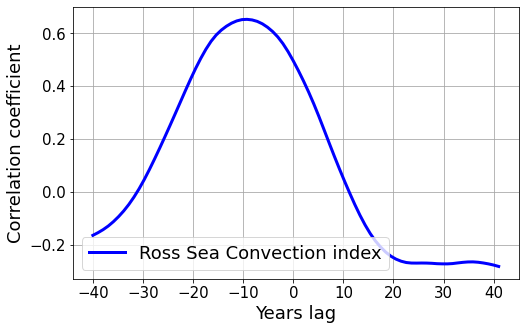

In [20]:
lag_time = 40

fig = plt.figure(figsize = (8,5))
lag_cor(coninx_ws, coninx_rs, lag_time,'b','Ross Sea Convection index')

''' !!!Problem need to be solved here !!!!'''
##### Q: Why -9 here? ######

plt.xlabel('Years lag', fontsize=18)
plt.ylabel('Correlation coefficient', fontsize=18)
plt.xticks(fontsize = 15)
plt.yticks(fontsize = 15)
plt.legend(fontsize = 18)
# plt.title('Lagged correlation (Ross Sea Convection index), year {}-{}, {}'.format(start_year, end_year, model_name), fontsize=18)

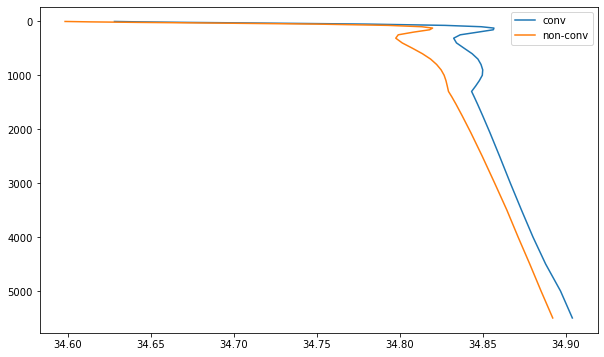

In [94]:
pltdata = ds_sigma15_new_avg - 1000
fig = plt.figure(figsize=(10,6))

pltdata1 = pltdata.where(coninx_ws>1).mean('year')
pltdata2 = pltdata.where(coninx_ws<-1).mean('year')
plt.plot(pltdata1, pltdata1.lev) #, norm=divnorm, 
plt.plot(pltdata2, pltdata2.lev)
plt.legend(['conv','non-conv'])
plt.gca().invert_yaxis()

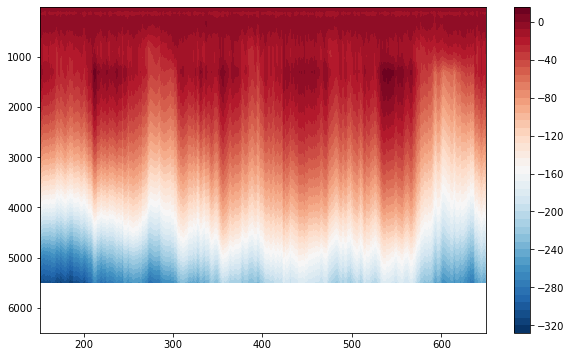

In [126]:
pltdata = ds_sigma15_new_avg - 1000
fig = plt.figure(figsize=(10,6))

pltdata0 = pltdata * dz

pltdata1 = pltdata0.cumsum(dim = 'lev') - pltdata * ds.lev_bnds[:,1]


im = plt.contourf(pltdata1.year, pltdata1.lev, pltdata1.transpose(), levels = 50, cmap=plt.cm.RdBu_r)#,  norm=colors.CenteredNorm()) #, norm=divnorm, 
plt.gca().invert_yaxis()
cbar = plt.colorbar(im)#, extend='none')

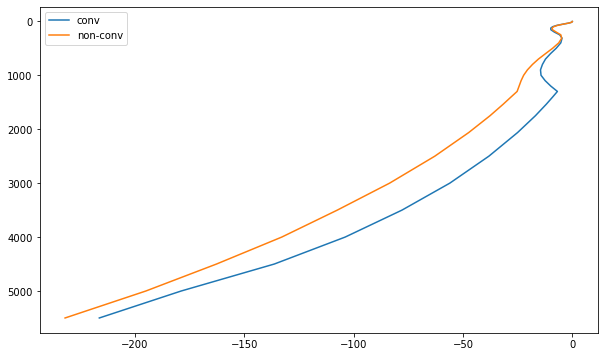

In [102]:
pltdata = ds_sigma15_new_avg - 1000
fig = plt.figure(figsize=(10,6))

pltdata0 = pltdata * dz
pltdata1 = pltdata0.cumsum(dim = 'lev') - pltdata * ds.lev_bnds[:,1]

pltdata_c = pltdata1.where(coninx_ws>1).mean('year')
pltdata_n = pltdata1.where(coninx_ws<-1).mean('year')
plt.plot(pltdata_c, pltdata_c.lev) #, norm=divnorm, 
plt.plot(pltdata_n, pltdata_n.lev)
plt.legend(['conv','non-conv'])
plt.gca().invert_yaxis()